# __텍스트로 이미지 검색하기__

- 튜토리얼 난이도: ★★☆☆☆
- 읽는데 걸리는 시간: 7분
- 사용 언어: [SQL](https://ko.wikipedia.org/wiki/SQL) (100%)
- 실행 파일 위치: tutorial/thanosql_search/search_image_by_text.ipynb
- 참고 문서: [Unsplash Dataset - Lite](https://unsplash.com/data), [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)

## 튜토리얼 소개

<div class="admonition note">
    <h4 class="admonition-title">텍스트 수치화 기술 이해하기</h4>
    <p>자연어를 컴퓨터가 이해하려면 자연어를 수치화 해야 합니다. 최근 <a href="https://en.wikipedia.org/wiki/BERT_(language_model)">BERT</a>나 <a href="https://en.wikipedia.org/wiki/GPT-3">GPT-3</a>와 같은 사전학습 모델에 대한 연구가 활발히 이루어지고 있으며, 주목할 만한 성과를 보여주고 있습니다. 이러한 모델들은 <a href="https://ko.wikipedia.org/wiki/%EC%9E%90%EA%B8%B0_%EC%A7%80%EB%8F%84_%ED%95%99%EC%8A%B5">자가 학습(Self-Supervised Learning)</a>을 기반으로 각 문장들의 의미를 파악하고 유사한 의미를 갖는 각 문장들을 가깝게 위치하도록 저차원 공간에 수치화하여 표현합니다. 문장 간의 순서를 무작위로 섞거나 일부 단어를 마스킹하는 방식 등을 이용해 각 문장/문맥의 참/거짓 여부를 판단함으로써 라벨링 작업이 없어도 학습이 가능하도록 지원합니다.</p>
</div>

텍스트와 이미지 같이 다른 형태의 입력 자료를 함께 다루는 문제를 멀티 모달(Multi-modal)이라고 합니다. "**CLIP: Connecting Text and Image**"은 대표적인 멀티 모달 모델로 수치화 된 저차원 공간에 대한 이해를 다루고 있습니다. 기존 모델이 이미지 자체의 <a href="https://ko.wikipedia.org/wiki/%ED%8A%B9%EC%A7%95_(%EA%B8%B0%EA%B3%84_%ED%95%99%EC%8A%B5)">특징(Feature)</a>만을 학습 했다면, 멀티 모달 모델에서는 이미지와 텍스트를 모두 입력 자료로 사용하면서 해당 이미지를 설명하는 텍스트에 대한 특징까지 동시에 학습할 수 있습니다. 또한, 텍스트와 이미지가 저차원 공간에 함께 위치함으로써 텍스트와 이미지 사이의 유사도를 판단할 수 있게 되며, 이를 응용하면 검색 알고리즘으로 사용할 수 있습니다.

ThanoSQL은 인공지능 알고리즘을 이용해서 데이터 세트를 수치화 합니다. 이렇게 수치화 된 데이터는 데이터베이스의 컬럼 내에 저장되고, 입력받은 텍스트의 수치화 결과와 유사도 계산을 통해 비슷한 이미지를 검색하는데 사용됩니다.

__아래는 ThanoSQL 텍스트-이미지 검색 알고리즘의 활용 및 예시 입니다.__

- 사용자가 보유하고 있는 이미지나 동영상에서 원하는 장면을 텍스트로 묘사하고 이와 가장 유사한 이미지를 검색합니다. 사용자가 검색하는 상품에 대한 키워드가 아닌 텍스트 기반의 설명을 듣고 가장 유사한 상품 이미지를 노출합니다.
- 유튜브 영상 등에서 내가 원하는 광고를 넣고 싶은 시간을 검색합니다. 여행 광고를 넣기 위해서 산이나 캠핑 장면 등이 나오는 장면을 손쉽게 검색하고 광고를 삽입합니다.

<div class="admonition note">
    <h4 class="admonition-title">본 튜토리얼에서는</h4>
    <p>👉 Unsplash는 20만 명 이상의 사진가들이 참여한 이미지들을 AI를 위한 데이터 세트로 무료로 공개했습니다. Unsplash Dataset - Lite는 25,000 장의 자연을 테마로한 이미지로 구성되어 있으며, 25,000 개의 키워드를 함께 제공합니다.</p>
</div>

이번 튜토리얼에서는 텍스트-이미지 검색 모델을 사용하여, ThanoSQL 워크스페이스 데이터베이스의 Unsplash Dataset - Lite 데이터 세트의 25,000 장의 이미지 중에서 텍스트로 원하는 이미지를 검색해 봅니다.

## __0. 데이터 세트 및 모델 준비__

ThanoSQL의 쿼리 구문을 사용하기 위해서는 [ThanoSQL 워크스페이스](https://docs.thanosql.ai/1.5/ko/getting_started/paas/workspace/lab/)에서 언급된 것처럼 API 토큰을 생성하고 아래의 쿼리를 실행해야 합니다.

In [ ]:
%load_ext thanosql
%thanosql API_TOKEN=<발급받은_API_TOKEN>

### __데이터 세트 준비__

In [2]:
%%thanosql
GET THANOSQL DATASET unsplash_data
OPTIONS (overwrite=True)

Success


<div class="admonition note">
    <h4 class="admonition-title">쿼리 세부 정보</h4>
    <ul>
        <li>"<strong>GET THANOSQL DATASET</strong>" 쿼리 구문을 사용하여 원하는 데이터 세트를 워크스페이스에 저장합니다.</li>
        <li>"<strong>OPTIONS</strong>" 쿼리 구문을 통해 <strong>GET THANOSQL DATASET</strong>에 사용할 옵션을 지정합니다.
        <ul>
            <li>"overwrite": 동일 이름의 데이터 세트가 존재하는 경우 덮어쓰기 가능 여부 설정. True일 경우 기존 데이터 세트는 새로운 데이터 세트로 변경됨 (bool, optional, True|False, default: False)</li>
        </ul>
        </li>
    </ul>
</div>

In [3]:
%%thanosql
COPY unsplash_data
OPTIONS (if_exists='replace')
FROM 'thanosql-dataset/unsplash_data/unsplash.csv'

Success


<div class="admonition note">
    <h4 class="admonition-title">쿼리 세부 정보</h4>
    <ul>
        <li>"<strong>COPY</strong>" 쿼리 구문을 사용하여 데이터베이스에 저장 할 테이블명을 지정합니다.</li>
        <li>"<strong>OPTIONS</strong>" 쿼리 구문을 통해 <strong>COPY</strong>에 사용할 옵션을 지정합니다.
        <ul>
            <li>"if_exists": 동일 이름의 테이블이 존재하는 경우 처리하는 방법 설정. 오류 발생, 기존 테이블에 추가, 기존 테이블 대체 (str, optional, 'fail'|'replace'|'append', default: 'fail')</li>
        </ul>
        </li>
    </ul>
</div>

### __모델 준비__

In [4]:
%%thanosql
GET THANOSQL MODEL clip
OPTIONS (
    model_name='tutorial_search_clip',
    overwrite=True
    )

Success


<div class="admonition note">
    <h4 class="admonition-title">쿼리 세부 정보</h4>
    <ul>
        <li>"<strong>GET THANOSQL MODEL</strong>" 쿼리 구문을 사용하여 원하는 모델을 워크스페이스 및 데이터베이스에 저장합니다.</li>
        <li>"<strong>OPTIONS</strong>" 쿼리 구문을 통해 <strong>GET THANOSQL MODEL</strong>에 사용할 옵션을 지정합니다.
        <ul>
            <li>“model_name”: 저장할 모델의 이름 (str, optional)</li>
            <li>"overwrite": 동일 이름의 모델이 존재하는 경우 덮어쓰기 가능 여부 설정. True일 경우 기존 모델은 새로운 모델로 변경됨 (bool, optional, True|False, default: False)</li>
        </ul>
        </li>
    </ul>
</div>

## __1. 데이터 세트 확인__

본 튜토리얼을 진행하기 위해 ThanoSQL 워크스페이스 데이터베이스에 저장되어 있는 __unsplash_data__ 테이블을 사용합니다. 아래의 쿼리 구문을 실행하고 테이블의 내용을 확인합니다.

In [5]:
%%thanosql
SELECT *
FROM unsplash_data
LIMIT 5

photo_id                                      image_path  \
0  XMyPniM9LF0  thanosql-dataset/unsplash_data/XMyPniM9LF0.jpg   
1  rDLBArZUl1c  thanosql-dataset/unsplash_data/rDLBArZUl1c.jpg   
2  cNDGZ2sQ3Bo  thanosql-dataset/unsplash_data/cNDGZ2sQ3Bo.jpg   
3  iuZ_D1eoq9k  thanosql-dataset/unsplash_data/iuZ_D1eoq9k.jpg   
4  BeD3vjQ8SI0  thanosql-dataset/unsplash_data/BeD3vjQ8SI0.jpg   

                                     photo_image_url  \
0  https://images.unsplash.com/uploads/1411949294...   
1  https://images.unsplash.com/photo-141633941111...   
2  https://images.unsplash.com/photo-142014251503...   
3  https://images.unsplash.com/photo-141487280988...   
4  https://images.unsplash.com/photo-141700759404...   

            photo_description  \
0    Woman exploring a forest   
1   Succulents in a terrarium   
2   Rural winter mountainside   
3     Poppy seeds and flowers   
4  Silhouette near dark trees   

                                      ai_description  
0              woman walking in the middle of forest  
1          succulent plants in clear glass terrarium  
2           rocky mountain under gray sky at daytime  
3  red common poppy flower selective focus phography  
4                            trees during night time

<div class="admonition note">
    <h4 class="admonition-title">데이터 테이블 이해하기</h4>
    <p><strong>unsplash_data</strong> 테이블은 아래와 같은 정보를 담고 있습니다.</p>
    <ul>
        <li>photo_id: 이미지의 고유 id</li>
        <li>image_path: 이미지가 위치한 경로</li>
        <li>photo_image_url: 웹사이트 unsplash에서의 원본 이미지 주소</li>
        <li>photo_description: 해당 이미지에 대해 사람이 작성한 짧은 설명</li>
        <li>ai_description: AI가 생성해낸 해당 이미지에 대한 설명</li>
    </ul>
</div>

/home/jovyan/thanosql-dataset/unsplash_data/XMyPniM9LF0.jpg


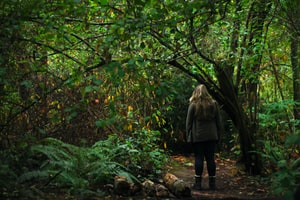

/home/jovyan/thanosql-dataset/unsplash_data/rDLBArZUl1c.jpg


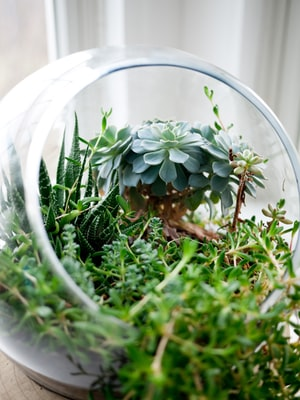

/home/jovyan/thanosql-dataset/unsplash_data/cNDGZ2sQ3Bo.jpg


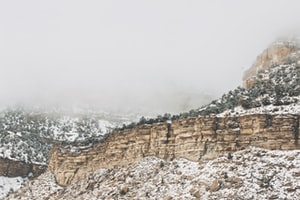

/home/jovyan/thanosql-dataset/unsplash_data/iuZ_D1eoq9k.jpg


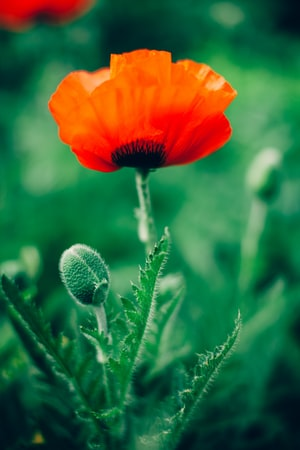

/home/jovyan/thanosql-dataset/unsplash_data/BeD3vjQ8SI0.jpg


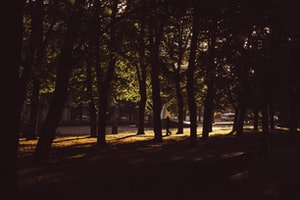

In [6]:
%%thanosql
PRINT IMAGE
AS
SELECT image_path
FROM unsplash_data
LIMIT 5

## __2. 사전 학습된 모델을 사용하여 이미지 수치화__

<div class="admonition danger">
    <h4 class="admonition-title">참고 사항</h4>
    <p>텍스트-이미지 검색 알고리즘은 학습에 오랜 시간이 걸리고 총 4억 개의 데이터 세트로 사전 학습된 모델을 사용하기 때문에 "<strong>BUILD MODEL</strong>" 쿼리 구문을 이용한 학습 과정을 본 튜토리얼에서는 생략합니다. 위에서 지정한 <strong>tutorial_search_clip</strong> 모델은 베이스 알고리즘으로 <strong>CLIP</strong>을 사용한 사전학습 된 모델을 가져와서 사용하게 됩니다. "<strong>CONVERT USING</strong>" 쿼리 구문을 실행하게 되면 사용자가 옵션으로 지정한 이름 (default: 'convert_result')으로 이미지가 수치화 된 컬럼이 자동으로 생성이 되며, "<strong>SEARCH IMAGE</strong>" 쿼리 구문을 실행하게 되면 사용자가 옵션으로 지정한 이름 (default: 'search_result')으로 이미지 유사도 컬럼이 자동으로 생성 됩니다.</p>
</div>

다음 "__CONVERT USING__" 쿼리 구문을 실행하여 __unsplash_data__ 이미지들을 수치화 합니다. 수치화 된 결과는 __unsplash_data__ 테이블에 사용자가 옵션으로 지정한 이름(default: 'convert_result')의 컬럼에 저장됩니다.  
(쿼리 실행 시 예상 소요 시간: 3 min)

In [7]:
%%thanosql
CONVERT USING tutorial_search_clip
OPTIONS (
    image_col='image_path',
    convert_type='image',
    batch_size=128,
    result_col='convert_result'
    )
AS
SELECT *
FROM unsplash_data

photo_id                                      image_path  \
0      XMyPniM9LF0  thanosql-dataset/unsplash_data/XMyPniM9LF0.jpg   
1      rDLBArZUl1c  thanosql-dataset/unsplash_data/rDLBArZUl1c.jpg   
2      cNDGZ2sQ3Bo  thanosql-dataset/unsplash_data/cNDGZ2sQ3Bo.jpg   
3      iuZ_D1eoq9k  thanosql-dataset/unsplash_data/iuZ_D1eoq9k.jpg   
4      BeD3vjQ8SI0  thanosql-dataset/unsplash_data/BeD3vjQ8SI0.jpg   
...            ...                                             ...   
24963  c7OrOMxrurA  thanosql-dataset/unsplash_data/c7OrOMxrurA.jpg   
24964  15IuQ5a0Qwg  thanosql-dataset/unsplash_data/15IuQ5a0Qwg.jpg   
24965  w8nrcXz8pwk  thanosql-dataset/unsplash_data/w8nrcXz8pwk.jpg   
24966  n1jHrRhehUI  thanosql-dataset/unsplash_data/n1jHrRhehUI.jpg   
24967  Ic74ACoaAX0  thanosql-dataset/unsplash_data/Ic74ACoaAX0.jpg   

                                         photo_image_url  \
0      https://images.unsplash.com/uploads/1411949294...   
1      https://images.unsplash.com/photo-141633941111...   
2      https://images.unsplash.com/photo-142014251503...   
3      https://images.unsplash.com/photo-141487280988...   
4      https://images.unsplash.com/photo-141700759404...   
...                                                  ...   
24963  https://images.unsplash.com/photo-159300793778...   
24964  https://images.unsplash.com/photo-159296761254...   
24965  https://images.unsplash.com/photo-159299937329...   
24966  https://images.unsplash.com/photo-159192792878...   
24967  https://images.unsplash.com/photo-159240763188...   

                         photo_description  \
0                 Woman exploring a forest   
1                Succulents in a terrarium   
2                Rural winter mountainside   
3                  Poppy seeds and flowers   
4               Silhouette near dark trees   
...                                    ...   
24963                                 None   
24964         Pearl earrings and seashells   
24965                                 None   
24966  Floral truck in the streets of Rome   
24967                                 None   

                                          ai_description  \
0                  woman walking in the middle of forest   
1              succulent plants in clear glass terrarium   
2               rocky mountain under gray sky at daytime   
3      red common poppy flower selective focus phography   
4                                trees during night time   
...                                                  ...   
24963                   black metal fence during daytime   
24964          white and brown seashell on white surface   
24965         leopard on brown tree trunk during daytime   
24966  woman in beige coat and white hat standing on ...   
24967  green plants on brown rocky mountain under blu...   

                                          convert_result  
0      [b'\xf4', b'\xc6', b'2', b'\xbe', b'\xb1', b'"...  
1      [b'F', b'\x08', b'\xbf', b'\xbe', b'\xc5', b'\...  
2      [b'G', b'\x07', b'\xb8', b'\xbe', b'C', b'\x93...  
3      [b'H', b'\x19', b'\xae', b'<', b'=', b'\xbe', ...  
4      [b'\xaa', b'\x8c', b'\x88', b'\xbe', b'\xbb', ...  
...                                                  ...  
24963  [b'N', b'\x88', b'\n', b'\xbe', b'p', b'\xcf',...  
24964  [b':', b'/', b'\xa1', b'\xbe', b'\xf4', b'\xbb...  
24965  [b'\x96', b'i', b'\x96', b'=', b'\xb6', b'\x96...  
24966  [b'\x82', b'\xf0', b'c', b'=', b'`', b'e', b'm...  
24967  [b'U', b'\x19', b'%', b'\xbe', b'!', b'Y', b'+...  

[24968 rows x 6 columns]

<div class="admonition note">
    <h4 class="admonition-title">쿼리 세부 정보</h4>
    <ul>
        <li>"<strong>CONVERT USING</strong>" 쿼리 구문은 <strong>tutorial_search_clip</strong> 모델을 이미지 수치화를 위한 알고리즘으로 사용합니다.</li>
        <li>"<strong>OPTIONS</strong>" 쿼리 구문을 통해 이미지 수치화 시 필요한 변수들을 정의합니다.
        <ul>
            <li>"image_col": 데이터 테이블에서 이미지의 경로를 담은 컬럼 (str, default: 'image_path')</li>
            <li>"convert_type": 수치화할 파일의 종류 (str, 'image'|'text', default: 'image')</li>
            <li>"batch_size": 한 번의 학습에서 읽는 데이터 세트 묶음의 크기 (int, optional, default: 16)</li>
            <li>"result_col": 데이터 테이블에서 수치화된 결과를 담을 컬럼 이름 (str, optional, default: 'convert_result')</li>
        </ul>
        </li>
    </ul>
</div>

다음 "__CONVERT USING__" 쿼리 구문을 실행하여 변환된 결과를 다른 __ThanoSQL__ 쿼리 구문들과 함께 활용할 수 있도록 새로운 테이블에 저장해봅시다.

In [8]:
%%thanosql
CREATE TABLE unsplash_data_convert AS 
SELECT * FROM (
    CONVERT USING tutorial_search_clip
    OPTIONS (
        image_col='image_path',
        convert_type='image',
        batch_size=128,
        result_col='convert_result'
        )
    AS
    SELECT *
    FROM unsplash_data
)

Success


## __3. 텍스트로 이미지 검색__

"__SEARCH IMAGE__" 쿼리 구문과 __tutorial_search_clip__ 모델을 사용하여 텍스트 기반 이미지 검색을 할 수 있습니다. 다음 쿼리 구문을 실행하여 'a black cat' 이라는 텍스트와 임베딩 된 __unsplash_data__ 이미지의 유사도를 계산합니다.

In [9]:
%%thanosql
SEARCH IMAGE
USING tutorial_search_clip
OPTIONS (
    search_by='text',
    search_input='a black cat',
    emb_col='convert_result',
    result_col='search_result'
    )
AS
SELECT *
FROM unsplash_data_convert

photo_id                                      image_path  \
0    UMyfDjQ6Ep8  thanosql-dataset/unsplash_data/UMyfDjQ6Ep8.jpg   
1    7XJ3d0xK444  thanosql-dataset/unsplash_data/7XJ3d0xK444.jpg   
2    m8HsSWh-y6E  thanosql-dataset/unsplash_data/m8HsSWh-y6E.jpg   
3    6ST6S6i9IGM  thanosql-dataset/unsplash_data/6ST6S6i9IGM.jpg   
4    aFyD5aWKu6k  thanosql-dataset/unsplash_data/aFyD5aWKu6k.jpg   
..           ...                                             ...   
995  VQ41v-gnd1M  thanosql-dataset/unsplash_data/VQ41v-gnd1M.jpg   
996  AtSgtZcxZFc  thanosql-dataset/unsplash_data/AtSgtZcxZFc.jpg   
997  XzOMokbcp0Q  thanosql-dataset/unsplash_data/XzOMokbcp0Q.jpg   
998  aWcJuh1mUhc  thanosql-dataset/unsplash_data/aWcJuh1mUhc.jpg   
999  Zs6T2rub2zw  thanosql-dataset/unsplash_data/Zs6T2rub2zw.jpg   

                                       photo_image_url  \
0    https://images.unsplash.com/photo-157712719502...   
1    https://images.unsplash.com/photo-157217373317...   
2    https://images.unsplash.com/photo-156855266009...   
3    https://images.unsplash.com/photo-1548620848-d...   
4    https://images.unsplash.com/photo-157850934606...   
..                                                 ...   
995  https://images.unsplash.com/photo-158956048611...   
996  https://images.unsplash.com/photo-150329107570...   
997  https://images.unsplash.com/photo-157616182589...   
998  https://images.unsplash.com/photo-1544460671-b...   
999  https://images.unsplash.com/photo-158179166724...   

                                     photo_description  \
0                                                 None   
1                                                 None   
2                                     simon the kitty.   
3    The cutest black cat to wake up to on a Sunday...   
4                                                 None   
..                                                 ...   
995                                               None   
996                           In the Smoke of Thinking   
997                                               None   
998                                               None   
999                                               None   

                         ai_description  \
0                             black cat   
1                             black cat   
2                      silver tabby cat   
3    close-up photography of bombay cat   
4                             black cat   
..                                  ...   
995    purple smoke in black background   
996                                None   
997   green-leafed plant during daytime   
998              brown tabby cat on bed   
999  green pine trees covered with snow   

                                        convert_result  search_result  
0    [b'[', b'Z', b'\xfe', b'>', b'\x94', b'\x95', ...       0.316560  
1    [b'\x9c', b'\xec', b'\x80', b'>', b'#', b'j', ...       0.311931  
2    [b'\xff', b')', b'\xa1', b'>', b'O', b'\xe2', ...       0.310819  
3    [b'Z', b'`', b'x', b'>', b'\x83', b'E', b'\x15...       0.310214  
4    [b'\xc6', b'\x97', b'V', b'>', b'\x0f', b'@', ...       0.309158  
..                                                 ...            ...  
995  [b'\xb7', b'\xba', b'\x16', b'>', b'G', b'l', ...       0.221887  
996  [b'\xa8', b'\xa7', b'\xb3', b'\xbc', b'\xd4', ...       0.221874  
997  [b'\xd8', b'\x94', b'\xc1', b'\xbd', b'T', b'\...       0.221858  
998  [b',', b'\x9a', b'Y', b'>', b'\xf4', b'\x93', ...       0.221827  
999  [b'?', b'\x8e', b'\x1c', b'\xbf', b'^', b'\xa4...       0.221822  

[1000 rows x 7 columns]

<div class="admonition note">
    <h4 class="admonition-title">쿼리 세부 정보</h4>
    <ul>
        <li>"<strong>SEARCH IMAGE [image|text|audio|video]</strong>" 쿼리 구문은 검색하고자 하는 이미지|텍스트|오디오|비디오 파일을 정의합니다.</li>
        <li>"<strong>USING</strong>"은 이미지 수치화에 사용할 모델을 정의합니다.</li>
        <li>"<strong>OPTIONS</strong>" 쿼리 구문을 통해 이미지 검색 시 필요한 변수들을 정의합니다.
        <ul>
                <li>"search_by": 검색할 때 사용할 이미지|텍스트|오디오|비디오 타입 (str)</li>
                <li>"search_input": 검색할 때 사용할 입력값 (str)</li>
                <li>"emb_col": 데이터 테이블에서 수치화된 결과를 담은 컬럼 (str)</li>
                <li>"result_col": 데이터 테이블에서 검색 결과를 담을 컬럼 이름 (str, optional, default: 'search_result')</li>
        </ul>
        </li>
        <li>"<strong>AS</strong>" 쿼리 구문은 검색에 사용할 임베딩 테이블을 정의합니다. <strong>unsplash_data</strong> 테이블을 사용합니다.</li>
    </ul>
</div>

아래 쿼리 구문을 실행하여 'a black cat' 텍스트와 가장 유사한 이미지 5개의 유사도를 확인합니다.

In [10]:
%%thanosql
SELECT image_path, search_result
FROM (
    SEARCH IMAGE
    USING tutorial_search_clip
    OPTIONS (
        search_by='text',
        search_input='a black cat',
        emb_col='convert_result',
        result_col='search_result',
        top_k=5
        )
    AS
    SELECT *
    FROM unsplash_data_convert
    )

image_path  search_result
0  thanosql-dataset/unsplash_data/UMyfDjQ6Ep8.jpg       0.316560
1  thanosql-dataset/unsplash_data/7XJ3d0xK444.jpg       0.311931
2  thanosql-dataset/unsplash_data/m8HsSWh-y6E.jpg       0.310819
3  thanosql-dataset/unsplash_data/6ST6S6i9IGM.jpg       0.310214
4  thanosql-dataset/unsplash_data/aFyD5aWKu6k.jpg       0.309158

<div class="admonition note">
    <h4 class="admonition-title">쿼리 세부 정보</h4>
    <ul>
        <li>"<strong>SEARCH IMAGE</strong>" 쿼리 구문은 입력한 텍스트와 이미지 사이의 유사도를 계산하여 반환합니다.</li>
        <li>첫 번째 "<strong>SELECT</strong>" 쿼리 구문은 괄호 안의 쿼리 결과에서 image_path 컬럼과 search_result 컬럼을 선택합니다.</li>
    </ul>
</div>

이전 쿼리 구문을 "__PRINT__"문과 함께 응용하여, 결과 이미지를 바로 확인할 수 있습니다.

/home/jovyan/thanosql-dataset/unsplash_data/UMyfDjQ6Ep8.jpg


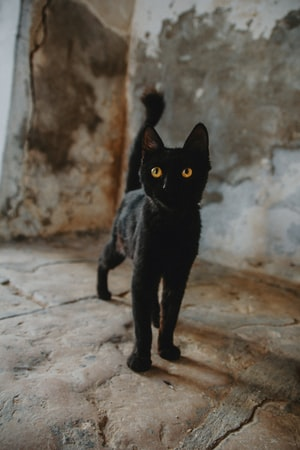

/home/jovyan/thanosql-dataset/unsplash_data/7XJ3d0xK444.jpg


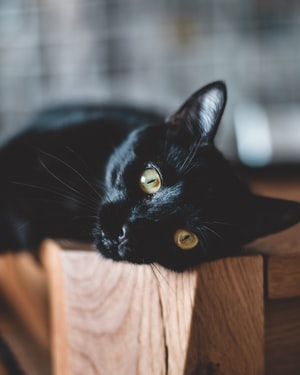

/home/jovyan/thanosql-dataset/unsplash_data/m8HsSWh-y6E.jpg


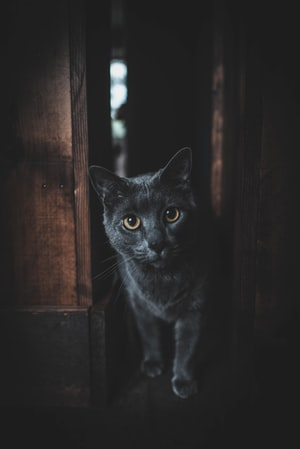

/home/jovyan/thanosql-dataset/unsplash_data/6ST6S6i9IGM.jpg


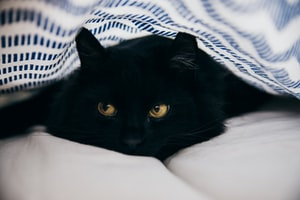

/home/jovyan/thanosql-dataset/unsplash_data/aFyD5aWKu6k.jpg


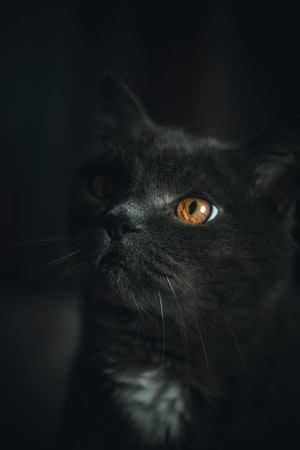

In [11]:
%%thanosql
PRINT IMAGE
AS (
    SELECT image_path, search_result
    FROM (
        SEARCH IMAGE
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='a black cat',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS
        SELECT *
        FROM unsplash_data_convert
        )
    )

<div class="admonition note">
    <h4 class="admonition-title">쿼리 세부 정보</h4>
    <p>이 쿼리는 위의 쿼리와 합쳐 세 단계로 구성됩니다.</p>
    <ul>
        <li>첫 번째 괄호 안의 "<strong>SELECT</strong>" 쿼리 구문을 통해 바로 위 단계의 결과를 생성합니다.</li>
        <li>"<strong>PRINT IMAGE</strong>" 쿼리 구문을 사용하여 해당 이미지를 출력합니다.</li>
    </ul>
</div>

/home/jovyan/thanosql-dataset/unsplash_data/jZUr3AuI8io.jpg


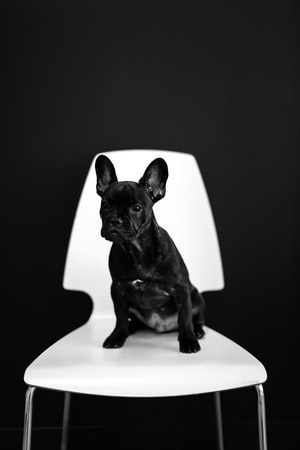

/home/jovyan/thanosql-dataset/unsplash_data/nnKBZTWzlMQ.jpg


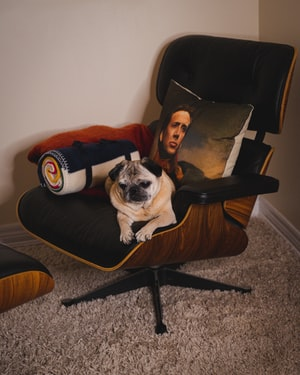

/home/jovyan/thanosql-dataset/unsplash_data/HG2KpOO0vSc.jpg


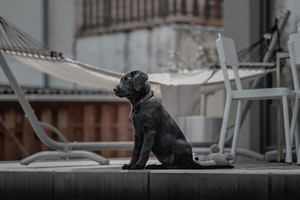

/home/jovyan/thanosql-dataset/unsplash_data/f6qFneRNwNI.jpg


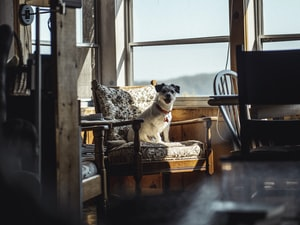

/home/jovyan/thanosql-dataset/unsplash_data/GKY4WDO3QgY.jpg


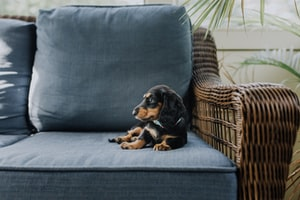

In [12]:
%%thanosql
PRINT IMAGE
AS (
    SELECT image_path, search_result
    FROM (
        SEARCH IMAGE
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='a dog on a chair',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS
        SELECT *
        FROM unsplash_data_convert
        )
    )

/home/jovyan/thanosql-dataset/unsplash_data/Xo4vJrtrmmA.jpg


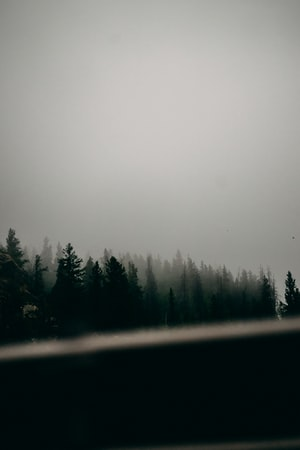

/home/jovyan/thanosql-dataset/unsplash_data/QheWOfwEUio.jpg


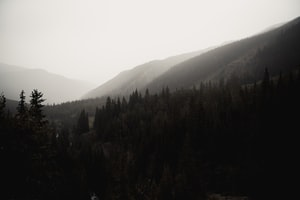

/home/jovyan/thanosql-dataset/unsplash_data/_zHYUQmWrzk.jpg


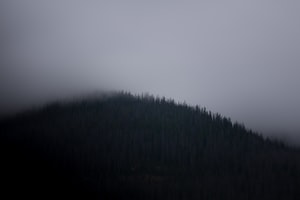

/home/jovyan/thanosql-dataset/unsplash_data/Tu_lH5CFFZw.jpg


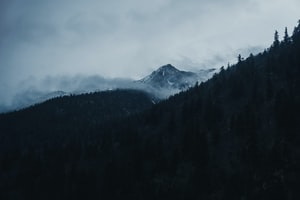

/home/jovyan/thanosql-dataset/unsplash_data/DfYPBHaOR04.jpg


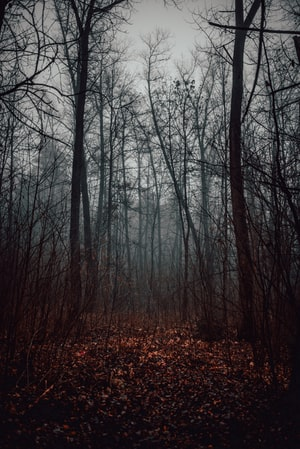

In [13]:
%%thanosql
PRINT IMAGE
AS (
    SELECT image_path, search_result
    FROM (
        SEARCH IMAGE
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='gloomy photos',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS
        SELECT *
        FROM unsplash_data_convert
        )
    )

/home/jovyan/thanosql-dataset/unsplash_data/nDLYtRqJtMw.jpg


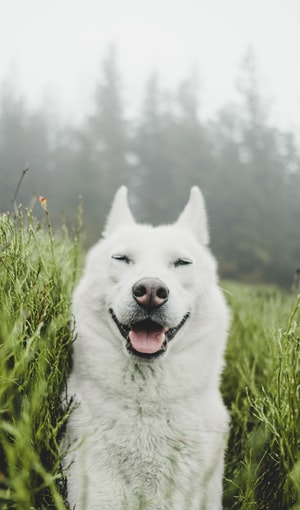

/home/jovyan/thanosql-dataset/unsplash_data/qNJpGSCv_Jc.jpg


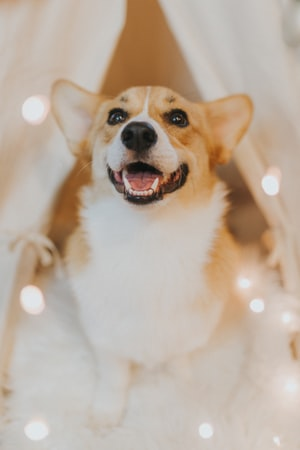

/home/jovyan/thanosql-dataset/unsplash_data/Yb5OBk-OxJY.jpg


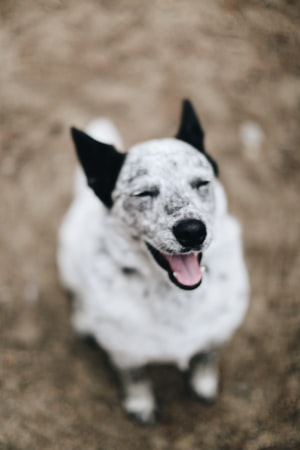

/home/jovyan/thanosql-dataset/unsplash_data/6etH6346MHE.jpg


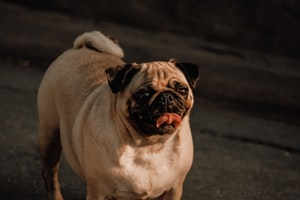

/home/jovyan/thanosql-dataset/unsplash_data/7GX5aICb5i4.jpg


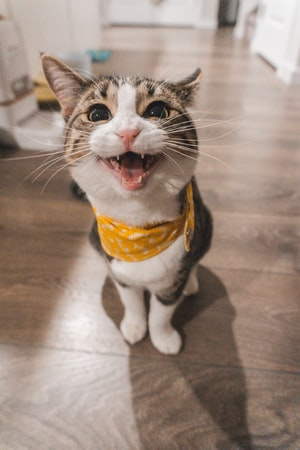

In [14]:
%%thanosql
PRINT IMAGE
AS (
    SELECT image_path, search_result
    FROM (
        SEARCH IMAGE
        USING tutorial_search_clip
        OPTIONS (
            search_by='text',
            search_input='the feeling when your program finally works',
            emb_col='convert_result',
            result_col='search_result',
            top_k=5
            )
        AS
        SELECT *
        FROM unsplash_data_convert
        )
    )

## __4. 튜토리얼을 마치며__

이번 튜토리얼에서는 unsplash 데이터 세트를 사용하여 이미지 수치화와 수치화 결과를 바탕으로한 텍스트를 통한 이미지 검색까지 진행해 보았습니다. 초급 단계의 튜토리얼인 만큼 간단한 쿼리를 통해 눈에 보이는 결과를 얻는 것 위주로 진행했습니다. 이미지 검색을 조금 더 다채로운 쿼리와 함께 사용한다면, 보다 원하는 결과에 가까운 값을 얻을 수 있을 것입니다.

* [나만의 데이터 업로드하기](https://docs.thanosql.ai/1.5/ko/getting_started/data_upload/)
* [나만의 데이터 테이블 생성하기](https://docs.thanosql.ai/1.5/ko/how-to_guides/ThanoSQL_query/COPY_SYNTAX/)
* [나만의 모델 업로드하기](https://docs.thanosql.ai/1.5/ko/how-to_guides/ThanoSQL_query/UPLOAD_MODEL_SYNTAX/)

<div class="admonition tip">
    <h4 class="admonition-title">나만의 서비스를 위한 모델 배포 관련 문의</h4>
    <p>ThanoSQL을 활용해 나만의 모델을 만들거나, 나의 서비스에 적용하는데 어려움이 있다면 언제든 아래로 문의주세요😊</p>
    <p>텍스트-이미지 검색 모델 구축 관련 문의: <a href="mailto:contact@smartmind.team">contact@smartmind.team</a></p>
</div>